In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import zipfile
import os


train_dir = '/kaggle/input/reduced/dogs-vs-cats/train'
test_dir = '/kaggle/input/reduced/dogs-vs-cats/test'

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()   # setting no of processors for loading data

def create_dataloader(
    train_dir : str,
    test_dir : str,
    transform : transforms.Compose,
    batch_size :int,
    num_workers : int = NUM_WORKERS
    ):

# use image folder to create dataset

    train_data = datasets.ImageFolder(train_dir,transform=transform)
    test_data = datasets.ImageFolder(test_dir,transform=transform)

    # To get Classes
    class_names = train_data.classes

    # Load the images
    train_data_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_data_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_data_loader,test_data_loader,class_names

In [5]:
img_size = 64          # 224 x 224

# Transformer_pipeline

manual_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
])

print(f"Manually created Transform : {manual_transform}")

Manually created Transform : Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
batch_size = 2

# Create data loaders
train_data_loader, test_data_loader, class_names = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=batch_size,
    transform=manual_transform
)

# Display class names
print("Class names:", class_names)

Class names: ['cats', 'dogs']


torch.Size([3, 64, 64]) tensor(0)


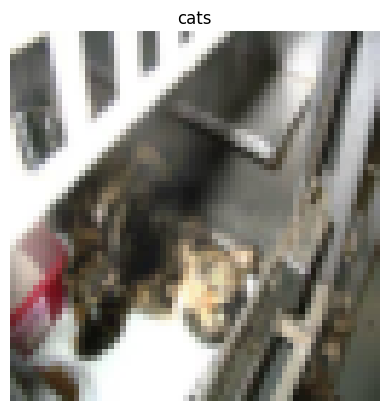

In [7]:
image_batch, label_batch = next(iter(train_data_loader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Displaying an image from the train data loader:


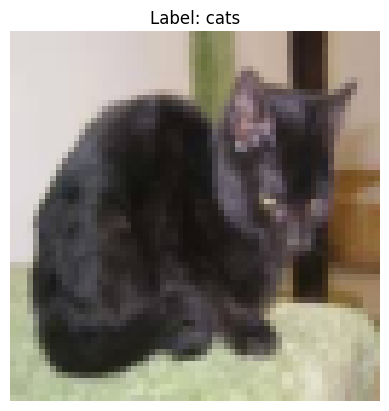

Displaying an image from the test data loader:


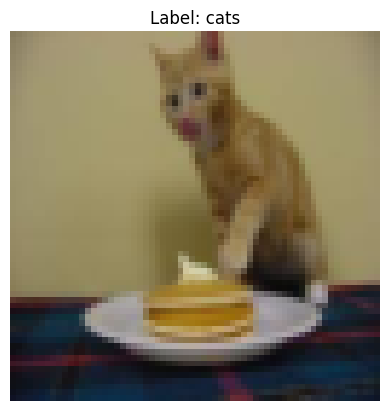

In [8]:
def show_image(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    img = np.transpose(images[0].numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.title(f'Label: {class_names[labels[0]]}')
    plt.axis('off')
    plt.show()

# Display an image from the train data loader
print("Displaying an image from the train data loader:")
show_image(train_data_loader)

# Display an image from the test data loader
print("Displaying an image from the test data loader:")
show_image(test_data_loader)

# **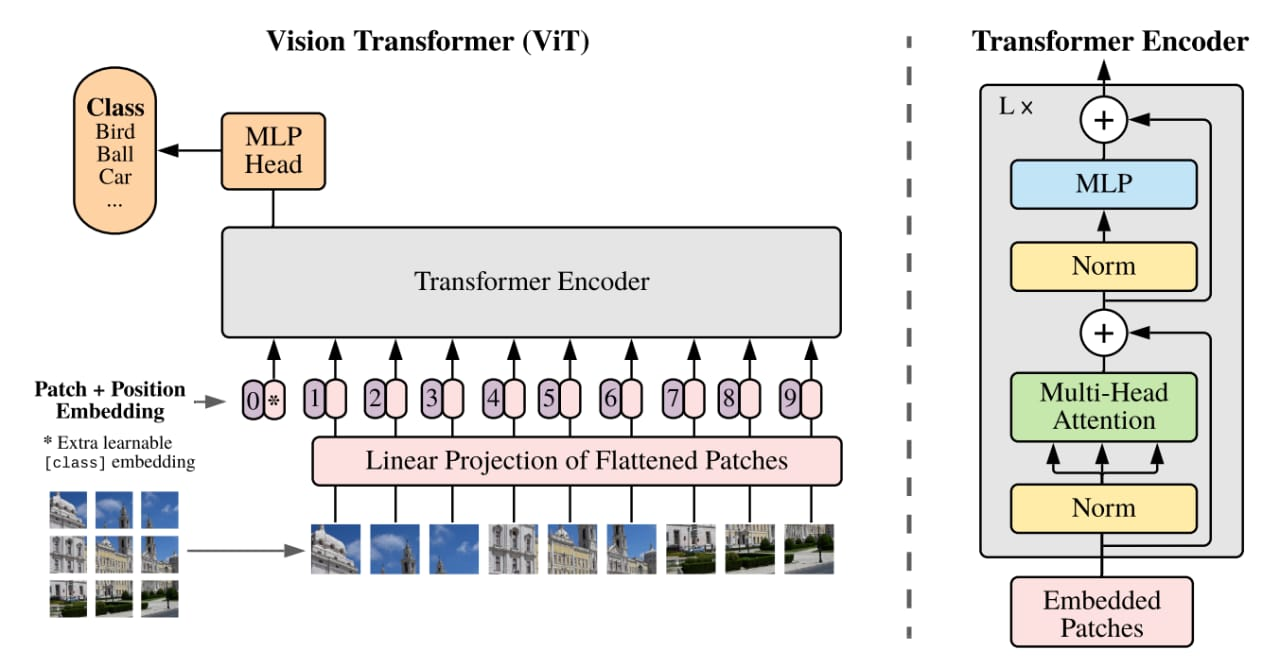Vision Transformer step-by-step**

In [9]:
## create Patch Embedding
class patching(nn.Module):
  def  __init__(self,in_channels:int=3,patch_size:int=8,embedding_dim:int=192): # 16x16x3

    super().__init__()

  # Now turn image into patches
    self.patcher = nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size = patch_size,
        stride= patch_size,
        padding = 0
    )

    # flatten patches into single dimension

    self.flatten = nn.Flatten(start_dim=2,         ## (196,768)
        end_dim = 3          ## (1,768,196)
    )

  def forward(self,x):
      img_res = x.shape[-1]
      assert img_res % patch_size == 0,f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

      x_patch = self.patcher(x)
      x_flattened = self.flatten(x_patch)

      return x_flattened.permute(0,2,1)

In [10]:
patch_size =8

In [11]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [12]:
patch = patching(in_channels=3,
                 patch_size=patch_size,embedding_dim=192)

print(f"Input image shape: {image.unsqueeze(0).shape}")

Input image shape: torch.Size([1, 3, 64, 64])


In [13]:
patch_embedded = patch(image.unsqueeze(0))
print(f"patched image shape: {patch_embedded.shape}")

patched image shape: torch.Size([1, 64, 192])


In [14]:
# batch_size,no_patches,embedding_dim

patch_embedded

tensor([[[ 0.2038,  0.1518,  0.0037,  ..., -0.3894, -0.2318,  0.6383],
         [ 0.0857,  0.0196,  0.0520,  ..., -0.6425, -0.1863,  0.9149],
         [ 0.1261, -0.0914,  0.1312,  ..., -0.6033, -0.1328,  0.9476],
         ...,
         [-0.0912,  0.2225,  0.0816,  ..., -0.3215, -0.1368,  0.3666],
         [-0.0453,  0.0964, -0.0267,  ..., -0.2492, -0.0782,  0.3925],
         [-0.0154,  0.0339, -0.0098,  ..., -0.2067, -0.0901,  0.3713]]],
       grad_fn=<PermuteBackward0>)

In [15]:
batch_size = patch_embedded.shape[0]
embedding_dimension = patch_embedded.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

Class token embedding shape: torch.Size([1, 1, 192])


In [16]:
patch_embedding_class_token = torch.cat((class_token, patch_embedded), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")


Patch embedding with class token shape: torch.Size([1, 65, 192])


### **Patch+Position_embedding**


In [17]:
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

Image tensor shape: torch.Size([3, 64, 64])


In [18]:
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

In [19]:
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Patch and position embedding shape: torch.Size([1, 65, 192])


In [20]:
patch_embedding_class_token

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.2038,  0.1518,  0.0037,  ..., -0.3894, -0.2318,  0.6383],
         [ 0.0857,  0.0196,  0.0520,  ..., -0.6425, -0.1863,  0.9149],
         ...,
         [-0.0912,  0.2225,  0.0816,  ..., -0.3215, -0.1368,  0.3666],
         [-0.0453,  0.0964, -0.0267,  ..., -0.2492, -0.0782,  0.3925],
         [-0.0154,  0.0339, -0.0098,  ..., -0.2067, -0.0901,  0.3713]]],
       grad_fn=<CatBackward0>)

# **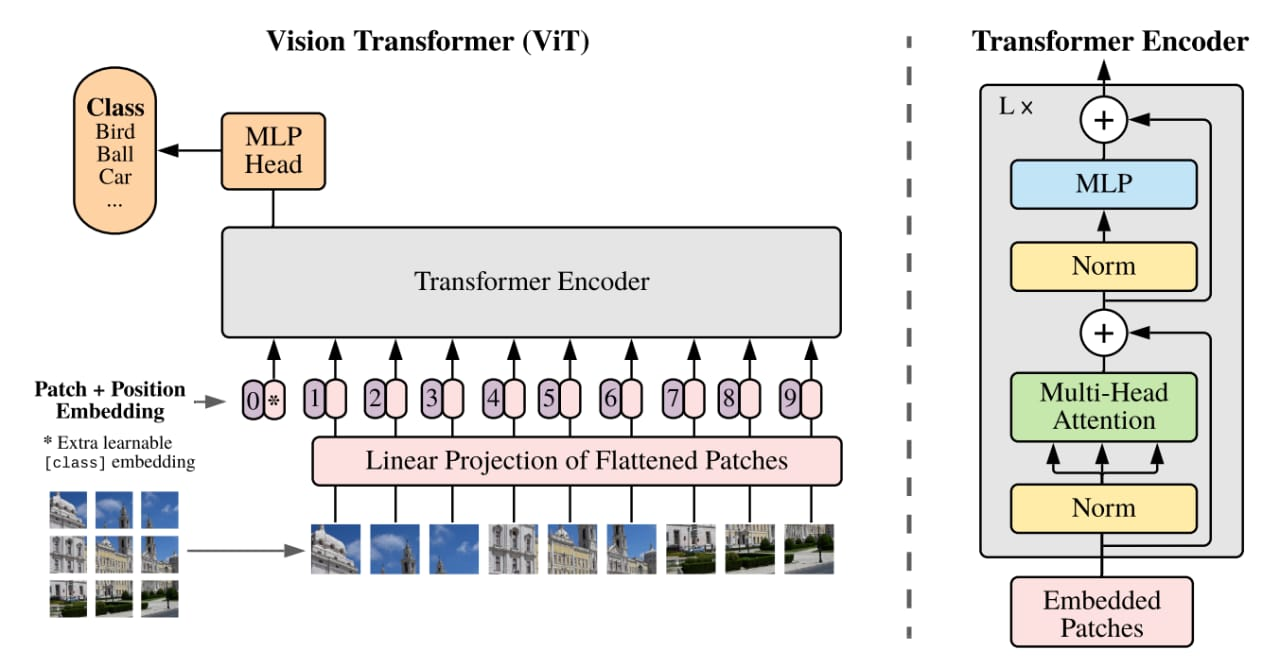Vision Transformer step-by-step**

# **Let us see the working of Transformer Encoder**

In [21]:
class mha(nn.Module):

  def __init__(self,
               num_heads=8,
               attn_dropout=0,
               embedding_dim=192):
    super().__init__()

    self.norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead = nn.MultiheadAttention(embed_dim=embedding_dim,
                                      num_heads=num_heads,
                                      dropout=attn_dropout,
                                      batch_first=True)

  def forward(self, x):
        x = self.norm(x)
        attn_output, _ = self.multihead(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output


In [22]:
### Now MLP Block in Transformer

class mlpblock(nn.Module):
  def __init__(
      self,
      embedding_dim = 192,
      mlp_size = 1536,                    # 3072 hidden layers
      dropout = 0.1,                 # 10% activations will be 0
):

    super().__init__()

    self.norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features =  mlp_size),
        nn.GELU(),              # Gaussian Error Linear Unit , computationally effficient in transformers
        nn.Dropout(p=dropout),

        nn.Linear(in_features = mlp_size,
                  out_features =  mlp_size*2),
        nn.GELU(),
        nn.Dropout(p=dropout),


        nn.Linear(in_features = mlp_size*2,
                  out_features =  mlp_size*4),
        nn.GELU(),
        nn.Dropout(p=dropout),

        nn.Linear(in_features = mlp_size*4,
                  out_features =  embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
        x = self.norm(x)
        x = self.mlp(x)
        return x




In [23]:
class TransformerEncoderBlock(nn.Module):

  def __init__(self,
                 embedding_dim:int=192,
                 num_heads:int=8,
                 mlp_size:int=1536,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()


        self.msa_block = mha(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block = mlpblock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

  def forward(self, x):

        # residual connection for MSA block
        x =  self.msa_block(x) + x

        # Create residual connection for MLP block
        x = self.mlp_block(x) + x

        return x



In [24]:
encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=encoder_block,
        input_size=(1, 65, 192), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 65, 192]         [1, 65, 192]         --                   True
├─mha (msa_block)                                  [1, 65, 192]         [1, 65, 192]         --                   True
│    └─LayerNorm (norm)                            [1, 65, 192]         [1, 65, 192]         384                  True
│    └─MultiheadAttention (multihead)              --                   [1, 65, 192]         148,224              True
├─mlpblock (mlp_block)                             [1, 65, 192]         [1, 65, 192]         --                   True
│    └─LayerNorm (norm)                            [1, 65, 192]         [1, 65, 192]         384                  True
│    └─Sequential (mlp)                            [1, 65, 192]         [1, 65, 192]         --                   True
│    │    └─Linear (0)                     

In [25]:
class ViT(nn.Module):
    def __init__(self, img_size=64,
                 in_channels=3,
                 patch_size=8,
                 num_transformer_layers=8,
                 embedding_dim=192,
                 mlp_size=1536,
                 num_heads=8,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = patching(in_channels, patch_size, embedding_dim)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim, num_heads, mlp_size, mlp_dropout, attn_dropout) for _ in range(num_transformer_layers)])
        self.norm = nn.LayerNorm(embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1)
        x = x + self.position_embedding
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        x = self.classifier(x[:, 0])
        return x

In [26]:
vit = ViT(num_classes=len(class_names))

In [28]:
import sys
sys.path.append("/kaggle/input/going-modular/going_modular")

In [29]:
import engine
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
torch.manual_seed(42)

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_data_loader,
                       test_dataloader=test_data_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7078 | train_acc: 0.4790 | test_loss: 0.6931 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.6927 | train_acc: 0.5140 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.6936 | train_acc: 0.5010 | test_loss: 0.6935 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.6940 | train_acc: 0.4830 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6936 | train_acc: 0.4990 | test_loss: 0.6932 | test_acc: 0.5000


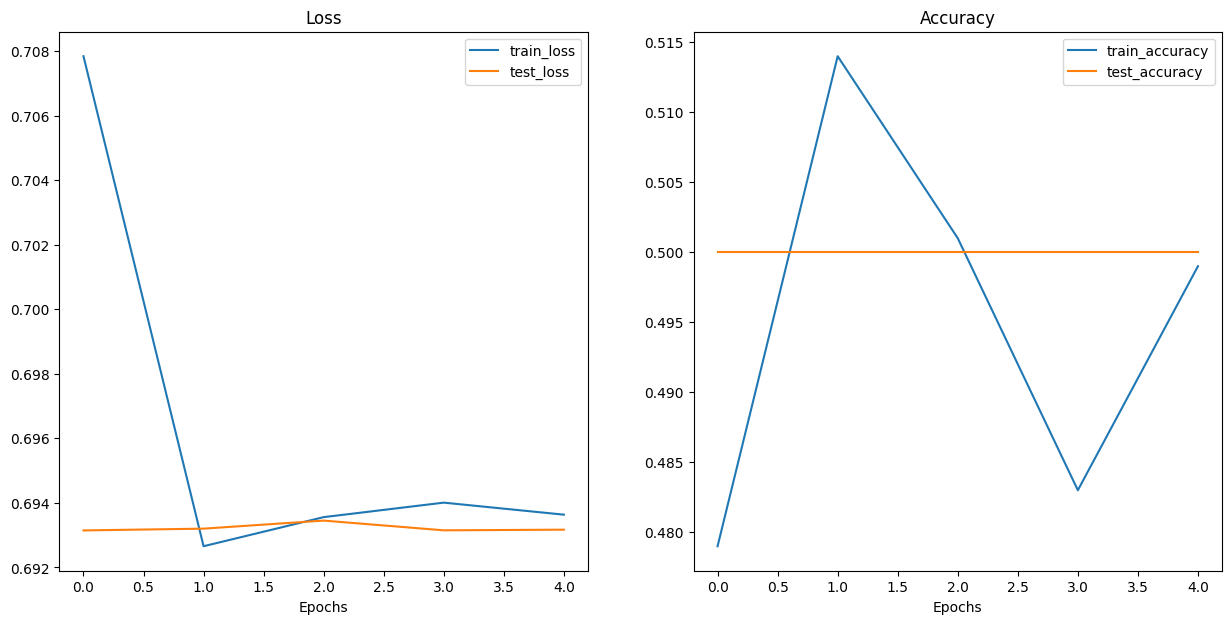

In [30]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curves(results)

## **Prediction**

In [31]:
import os
import json

# Define the path to the kaggle.json file you just downloaded
kaggle_json_path = '/kaggle/input/kaggle-api/kaggle.json'

# Make sure the .kaggle directory exists
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy the kaggle.json file to the .kaggle directory
with open(kaggle_json_path, 'r') as f:
    kaggle_data = json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_data, f)

# Set permissions to read and write for the user
os.chmod('/root/.kaggle/kaggle.json', 0o600)


Selected image path: /kaggle/input/reduced/dogs-vs-cats/test/dogs/dog.10249.jpg


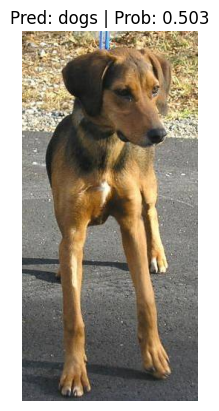

In [52]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
from pathlib import Path

def pred_and_plot_image(
   model: torch.nn.Module,
   class_names: List[str],
   image_path: str,
   image_size: Tuple[int, int] = (64, 64),
   transform: transforms = None,
   device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
   img = Image.open(image_path)
   if transform is not None:
       image_transform = transform
   else:
       image_transform = transforms.Compose([
           transforms.Resize(image_size),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
       ])

   model.to(device)
   model.eval()
   with torch.inference_mode():
       transformed_image = image_transform(img).unsqueeze(dim=0)
       target_image_pred = model(transformed_image.to(device))
       target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
       target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

   plt.figure()
   plt.imshow(img)
   plt.title(f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}")
   plt.axis(False)

test_folder = Path("/kaggle/input/reduced/dogs-vs-cats/test")
all_files = list(test_folder.glob('*/*'))
random_image_path = random.choice(all_files)
print(f"Selected image path: {random_image_path}")
pred_and_plot_image(model=vit, image_path=str(random_image_path), class_names=class_names)